In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import tqdm as tqdm
import torch
import seaborn as sn
%matplotlib inline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from sklearn.model_selection import train_test_split

#SKLEARN MODELS HERE

from sklearn import metrics


In [2]:
def LoadDataSet(Flag):
    
        
    stances = pd.read_csv('train_stances.csv')
    bodies = pd.read_csv('train_bodies.csv')
    MainData = stances.merge(bodies,on='Body ID')
    if Flag == 'RelatedUnrelated':
        Mapper = {'unrelated':0,'discuss':1,'agree':1,'disagree':1}   #Not unrelated implies related
        
        MainData['Stance'] = MainData['Stance'].map(Mapper)
        
    if Flag == 'AgreeDisagreeDiscuss':
        Mapper = {'disagree':0,'discuss':1,'agree':2}
        MainData = MainData[MainData['Stance'] !='unrelated'].copy()
        MainData['Stance'] = MainData['Stance'].map(Mapper)
        
    
    return MainData

DataSet = LoadDataSet('RelatedUnrelated')
DataSet.iloc(0)[0]

Headline       Police find mass graves with at least '15 bodi...
Body ID                                                      712
Stance                                                         0
articleBody    Danny Boyle is directing the untitled film\n\n...
Name: 0, dtype: object

<h3> TF-IDF </h3>

In [3]:
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

In [4]:
DataSet['FullInput'] = DataSet['Headline'] + ',' + DataSet['articleBody']
DataSet.sample(8)

X_train, X_val, y_train, y_val = train_test_split(DataSet['FullInput'], 
                                                  DataSet['Stance'].values,
                                                  test_size=0.25,
                                                  random_state=0)
tfidf = TfidfVectorizer(decode_error='ignore',lowercase=True,min_df=7,max_features=1024)
trainTFIDF = tfidf.fit_transform(X_train.values.astype('U'))
valTFIDF = tfidf.transform(X_val.values.astype('U'))

In [5]:
trainTFIDF

<37479x1024 sparse matrix of type '<class 'numpy.float64'>'
	with 4390030 stored elements in Compressed Sparse Row format>

<h3> BERT Embeddings </h3>

In [6]:
#import torch
from transformers import BertTokenizer,BertModel,BertTokenizerFast
import pickle
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

C:\Users\Acer Triton 300\.conda\envs\DeepLearningAttempt2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
BERTTokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
BERTModel = BertModel.from_pretrained('bert-base-uncased')
BERTModel = BERTModel.to(device)
BATCH_SIZE = 32


In [8]:
DIRECTORY = './'
if not os.path.exists(DIRECTORY+'/TransformerTOKENS.pickle'):

  headlines = list(DataSet['Headline'])
  bodies = list(DataSet['articleBody'])
  embeddings = torch.empty((len(headlines),768))    #Each embedding is 768 length there are len(headlines) embeddings
  for i in tqdm.tqdm(range(0,len(headlines),BATCH_SIZE)):
      headline = headlines[i:i+BATCH_SIZE]
      body = bodies[i:i+BATCH_SIZE]
      tokens = BERTTokenizer(text=headline,text_pair=body,return_tensors='pt',truncation='only_second',padding=True)
      tokens = tokens.to(device)
      with torch.no_grad():
          outputs = BERTModel(**tokens)
      embeddings[i:i+BATCH_SIZE] = outputs[0][:,0,:]
  with open(DIRECTORY+'/TransformerTOKENS.pickle','wb') as file:
    pickle.dump(embeddings,file)

else:
  with open(DIRECTORY+'/TransformerTOKENS.pickle','rb') as file:
    embeddings = pickle.load(file)


In [9]:
#X_train,X_val,y_train,y_val = train_test_split(embeddings,DataSet['Stance'],test_size=0.25,random_state=0)
len(embeddings[0])

768

<h3> XGBoost with Transformer Embeddings </h3>

In [10]:
#FROM PRACTICAL 1
from sklearn.metrics import confusion_matrix,accuracy_score,roc_auc_score,roc_curve,auc,f1_score
def plot_confusion_matrix(y_test, y_pred):
    ''' Plot the confusion matrix for the target labels and predictions '''
    cm = confusion_matrix(y_test, y_pred)

    # Create a dataframe with the confusion matrix values
    df_cm = pd.DataFrame(cm, range(cm.shape[0]),
                  range(cm.shape[1]))

    # Plot the confusion matrix
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True,fmt='.0f',cmap="YlGnBu",annot_kws={"size": 10}) # font size
    plt.show()
    
def plot_roc_curve(y_test, y_pred):
    ''' Plot the ROC curve for the target labels and predictions'''
    fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
    roc_auc= auc(fpr,tpr)
    plt.figure(figsize=(12, 12))
    ax = plt.subplot(121)
    ax.set_aspect(1)
    
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    return roc_auc

In [11]:
from xgboost import XGBClassifier

In [12]:
X_train,X_val,y_train,y_val = train_test_split(embeddings,DataSet['Stance'],test_size=0.25,random_state=0)

In [13]:
params = {
    'gpu_id':           0,
    'n_estimators':     325,
    'eta':              0.5,
}

XGBoostTransformer = XGBClassifier(**params)

XGBoostTransformer.fit(X_train, y_train,eval_set=[(X_train,y_train),(X_val,y_val)],verbose=50)

C:\Users\Acer Triton 300\.conda\envs\DeepLearningAttempt2\lib\site-packages\xgboost\core.py:160: UserWarning: [04:27:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:45: `gpu_id` is deprecated since2.0.0, use `device` instead. E.g. device=cpu/cuda/cuda:0
  warnings.warn(smsg, UserWarning)


[0]	validation_0-logloss:0.25800	validation_1-logloss:0.26535
[50]	validation_0-logloss:0.00055	validation_1-logloss:0.03617
[100]	validation_0-logloss:0.00022	validation_1-logloss:0.03544
[150]	validation_0-logloss:0.00015	validation_1-logloss:0.03519
[200]	validation_0-logloss:0.00012	validation_1-logloss:0.03486
[250]	validation_0-logloss:0.00011	validation_1-logloss:0.03492
[300]	validation_0-logloss:0.00010	validation_1-logloss:0.03478
[324]	validation_0-logloss:0.00009	validation_1-logloss:0.03482


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.5, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=325,
              n_jobs=None, ...)

In [16]:
print("train score:", XGBoostTransformer.score(X_train, y_train))
print("val score:", XGBoostTransformer.score(X_val, y_val))


train score: 1.0
val score: 0.9903145761626511


In [17]:
Y_pred = XGBoostTransformer.predict(X_val)

In [18]:
print(metrics.classification_report(y_val, Y_pred,labels=[0,1],target_names=['Unrelated','Related'],digits=6))

              precision    recall  f1-score   support

   Unrelated   0.992004  0.994728  0.993364      9105
     Related   0.985727  0.978453  0.982077      3388

    accuracy                       0.990315     12493
   macro avg   0.988866  0.986591  0.987721     12493
weighted avg   0.990302  0.990315  0.990303     12493



<h3> XGBoost with TFIDF Embeddings </h3>

In [19]:
trainTFIDF.astype(np.float32)
y_train

4220     0
34910    0
47942    1
29825    0
18154    0
        ..
21243    1
45891    0
42613    1
43567    0
2732     0
Name: Stance, Length: 37479, dtype: int64

In [20]:
#from xgboost import XGBClassifier

In [21]:
params = {
    'gpu_id':           0,
    'n_estimators':     325,
    
    'eta':              0.5,
    
}


XGBoostTFIDF = XGBClassifier(**params)
XGBoostTFIDF.fit(trainTFIDF.astype(np.float32), y_train,eval_set=[(trainTFIDF.astype(np.float32),y_train),(valTFIDF.astype(np.float32),y_val)],verbose=50)


[0]	validation_0-logloss:0.52565	validation_1-logloss:0.53114
[50]	validation_0-logloss:0.16127	validation_1-logloss:0.19740
[100]	validation_0-logloss:0.08535	validation_1-logloss:0.13131
[150]	validation_0-logloss:0.05081	validation_1-logloss:0.10246
[200]	validation_0-logloss:0.03300	validation_1-logloss:0.08780
[250]	validation_0-logloss:0.02221	validation_1-logloss:0.07999
[300]	validation_0-logloss:0.01562	validation_1-logloss:0.07462
[324]	validation_0-logloss:0.01343	validation_1-logloss:0.07324


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.5, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=325,
              n_jobs=None, ...)

In [23]:
print("train score:", XGBoostTFIDF.score(trainTFIDF.astype(np.float32), y_train))
print("val score:", XGBoostTFIDF.score(valTFIDF.astype(np.float32), y_val))



train score: 0.9998132287414285
val score: 0.9752661490434643


In [24]:
Y_pred = XGBoostTFIDF.predict(valTFIDF.astype(np.float32))

In [25]:
print(metrics.classification_report(y_val, Y_pred,labels=[0,1],target_names=['Unrelated','Related'],digits=6))

              precision    recall  f1-score   support

   Unrelated   0.975049  0.991433  0.983173      9105
     Related   0.975889  0.931818  0.953344      3388

    accuracy                       0.975266     12493
   macro avg   0.975469  0.961626  0.968259     12493
weighted avg   0.975276  0.975266  0.975083     12493



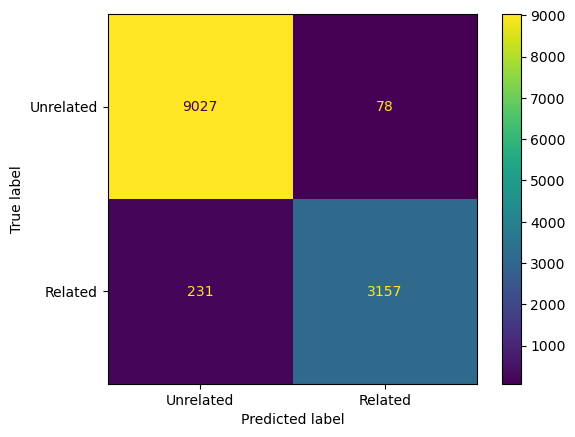

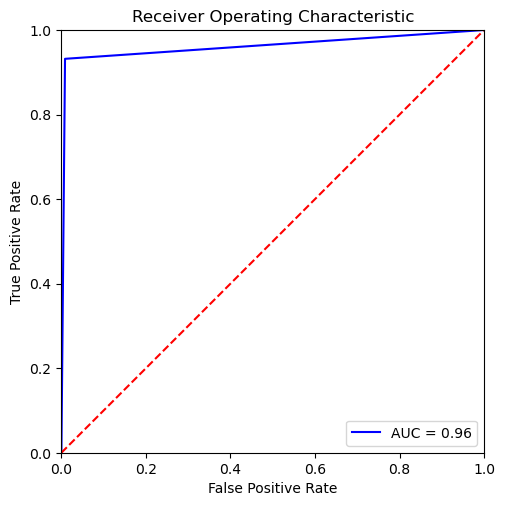

0.9616257301183165

In [26]:
#plot_confusion_matrix(y_val, Y_pred)
CM = confusion_matrix(y_val,Y_pred,labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=CM,display_labels=['Unrelated','Related'])
disp.plot()
plot_roc_curve(y_val, Y_pred)

<h3> deep model </h3>
<p>Bi-directional LSTM </p>

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim

#Code adapted from https://www.kaggle.com/code/mehmetlaudatekman/lstm-text-classification-pytorch
class LSTM(nn.Module):
    def __init__(self):
        super(LSTM,self).__init__()
        self.lstm = nn.LSTM(1024,256,num_layers=2,bidirectional=True,dropout=0.5,batch_first=True)
        self.linear = nn.Linear(512,2)
        self.drop = nn.Dropout(p=0.3)
    def forward(self,x):
        ##IF BERT USE BERT
        _,(hidden,cn) = self.lstm(x)
        hidden = self.drop(torch.cat((hidden[-2,:,:],hidden[-1,:,:]),dim=1))
        output = self.linear(hidden)
        out = nn.functional.softmax(output,dim=1)
        return out
#HyperParams

input_size = 2048
num_classes = 2
hidden_size = 256
num_layers = 2
kernel_size = 3
dropout = 0.1
learning_rate = 0.001
batch_size = 64
num_epochs = 15
model = LSTM()
trainTFIDF

<37479x1024 sparse matrix of type '<class 'numpy.float64'>'
	with 4390030 stored elements in Compressed Sparse Row format>

<h3> DataLoader for TFIDF </h3>

<p> Embed first to save on training time <p>

In [28]:
##Some Better DataLoader
from torch.utils.data import DataLoader, TensorDataset,Dataset,random_split
class dataset(Dataset):
    def __init__(self,headlines,bodies,labels,Tfidf=True,tokenizer=None,ThreeClass=False,EndToEnd=False):
        self.headlines = list(headlines)
        self.bodies = list(bodies)
        self.Tfidf = Tfidf
        
        self.embeddings = embeddings
        if EndToEnd:
            self.embeddings = EndToEndEmbeddings
        if ThreeClass:
            self.embeddings = embeddingsThreeClass
        self.labels = list(labels)
        if Tfidf:
            
            self.tfidfInputs = [tfidf.transform([self.headlines[x] +',' + self.bodies[x]]).toarray() for x in range(len(self.headlines))]
        else:
            self.tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
            #self.BertInputs = [self.tokenizer(text=self.headlines[x],text_pair=self.bodies[x],return_tensors='pt',truncation='only_second',padding='max_length',max_length=512) for x in tqdm.tqdm(range(len(self.headlines)))]
            
    def __len__(self):
        return len(self.bodies)
    
    def __getitem__(self,x):
        
        ##TFIDF
        if self.Tfidf:
            
        #tokenised = tfidf.transform([self.headlines[x] + ',' + self.bodies[x]]).toarray()
            X = torch.from_numpy(self.tfidfInputs[x].astype(np.float32))
            return [X,torch.from_numpy(np.array(self.labels[x])).long()]
        else:
            # tokenised = self.tokenizer(text=self.headlines[x],text_pair=self.bodies[x],return_tensors='pt',truncation='only_second',padding='max_length',max_length=128)
            
            return [self.embeddings[x],torch.from_numpy(np.array(self.labels[x])).long()]
    

In [30]:
headlines = list(DataSet['Headline'])
print('yes')
bodies = list(DataSet['articleBody'])
labels = list(DataSet['Stance'])
print('yes')
test = dataset(headlines,bodies,labels)

yes
yes


In [33]:
from sklearn.metrics import accuracy_score

In [34]:
def Train(model,loader,epochs,weights,name,ThreeClass=False):
    criterion = nn.CrossEntropyLoss(weight=weights)
    optimizer = optim.Adam(model.parameters(),lr=0.001)
    for epoch in range(0,epochs):
        totalLoss = 0
        for i,batch in tqdm.tqdm(enumerate(loader)):
            optimizer.zero_grad()
            model.train()
            X,y = batch[0],batch[1]
            # if isinstance(model,LSTMBert):
            #     for key in X.keys():
            #         X[key] = X[key].to(device).squeeze(1)
            X = X.to(device)
            y = y.to(device)

            pred = model(X)
            loss = criterion(pred,y)
            loss.backward()
            optimizer.step()
            totalLoss += loss.item()
        print(f'Epoch: {epoch +1},Loss: {totalLoss/len(loader)}')
        if ThreeClass:
            EvaluateThreeClass(model,test_loader,name)
        else:
            
            Evaluate(model,test_loader,name)
        
def Evaluate(model,loader,name,Final=False):
    model.eval()
    
    Predictions = []
    TrueValues = []
    with torch.no_grad():
        for i,batch in enumerate(loader):
            
            
            X,y = batch[0],batch[1]

            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            predictedClass = torch.max(pred,1)[1]
            Predictions.extend(predictedClass.cpu().numpy())
            TrueValues.extend(y.cpu().numpy())
            #print(y)
    
    #plot_confusion_matrix(TrueValues,Predictions)
    #auc = plot_roc_curve(TrueValues, Predictions)
            
    file = open(f'{name}.txt','a')

    fpr, tpr, thresholds = roc_curve(TrueValues, Predictions, pos_label=1)
    roc_auc= auc(fpr,tpr)
    print(f'Evaluation AUC: {roc_auc}')
    accuracy = accuracy_score(TrueValues,Predictions)
    print(f'Evaluation Accuracy: {accuracy}')
    f1 = f1_score(TrueValues,Predictions)
    print(f'F1 Score: {f1}')
    print('\n')
    if Final == False:
        
        file.writelines(f'ROC:{roc_auc},ROC:{accuracy},F1:{f1}\n')
    
    if Final == True:
        CM = confusion_matrix(TrueValues,Predictions,labels=[0,1])
        disp = ConfusionMatrixDisplay(confusion_matrix=CM,display_labels=['Unrelated','Related'])
        disp.plot()
        
        
        print(metrics.classification_report(TrueValues, Predictions,labels=[0,1],target_names=['Unrelated','Related'],digits=6))
    # print(Predictions)
    # print(TrueValues)
            
    
        

<h3> Train LSTM with tfidf embeddings </h3>

<p> Using weighted cross entropy loss to overcome class imbalance </p>

In [40]:
TRAIN = False
model = LSTM()

model = model.to(device)
if (not os.path.exists(DIRECTORY+'/LSTM_TFIDF_2CLASS')) or TRAIN==True:
    
    train_size = int(0.75 * len(test))
    test_size = len(test) - train_size
    train_dataset,test_dataset = random_split(test,[train_size,test_size])
    classCounts = {0:0,1:1}
    for _,label in train_dataset:
        temp = (int(label.cpu().numpy()))
        #print(temp)
        classCounts[temp] += 1
    print(classCounts)    #Inbalance more class 0 then 1
    counts = [classCounts[0],classCounts[1]]
    total = sum(counts)
    print(total)
    weights = [total / c for c in counts]
    weights = torch.FloatTensor(weights).to(device)
    train_loader = DataLoader(train_dataset,batch_size=32,shuffle=True)
    test_loader = DataLoader(test_dataset,batch_size=32)

    Train(model,train_loader,50,weights,'LSTM_TFIDF_2CLASS')
    torch.save(model.state_dict(),'LSTM_TFIDF_2CLASS')
else:
    model.load_state_dict(torch.load('LSTM_TFIDF_2CLASS'))
    model.eval()
Evaluate(model,test_loader,'')

Evaluation AUC: 0.8920530637372802
Evaluation Accuracy: 0.9077883614824301
F1 Score: 0.8355695118469882




Evaluation AUC: 0.8929690066420901
Evaluation Accuracy: 0.9094693028095734
F1 Score: 0.8344797307185716


              precision    recall  f1-score   support

   Unrelated   0.947351  0.928236  0.937696      9169
     Related   0.812482  0.857702  0.834480      3324

    accuracy                       0.909469     12493
   macro avg   0.879917  0.892969  0.886088     12493
weighted avg   0.911466  0.909469  0.910234     12493



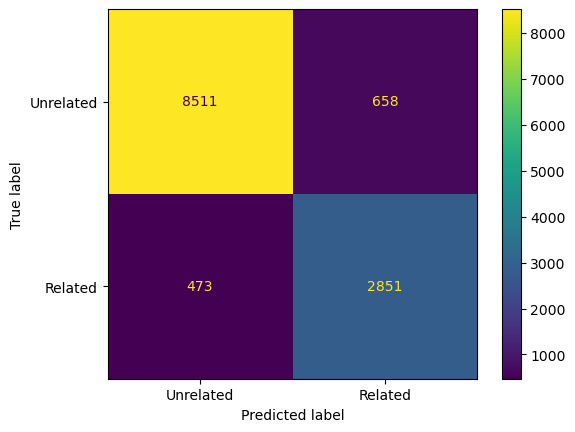

In [41]:

train_size = int(0.75 * len(test))
test_size = len(test) - train_size
train_dataset,test_dataset = random_split(test,[train_size,test_size])
train_loader = DataLoader(train_dataset,batch_size=32,shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=32)

train_dataset,test_dataset = random_split(test,[train_size,test_size])
Evaluate(model,test_loader,'',Final=True)

In [42]:
class LSTMBert(nn.Module):
    def __init__(self):
        super(LSTMBert,self).__init__()
        #self.BERT = bert
        #self.BERT.to(device)
        ##BERT embedding dimension = 768
        self.lstm = nn.LSTM(768,256,num_layers=2,bidirectional=True,dropout=0.5,batch_first=True)
        self.linear = nn.Linear(512,2)
        self.drop = nn.Dropout(p=0.3)
    def forward(self,x):
        ##IF BERT USE BERT
        #with torch.no_grad():
        #    x = self.BERT(**x)[0]
        #print(x.shape)
        x = x.unsqueeze(1)
        Test,(hidden,cn) = self.lstm(x)
        #print(hidden.shape)
        # print(Test)
        # print(hidden)
        # print(cn)
        hidden = self.drop(torch.cat((hidden[-2,:,:],hidden[-1,:,:]),dim=1))
        output = self.linear(hidden)
        out = nn.functional.softmax(output,dim=1)
        return out
#HyperParams




In [43]:
TRAIN = False
model = LSTMBert()
headlines = list(DataSet['Headline'])

bodies = list(DataSet['articleBody'])
labels = list(DataSet['Stance'])
model = model.to(device)
if (not os.path.exists(DIRECTORY+'/LSTM_BERT_2CLASS')) or TRAIN==True:
    BertDataLoader = dataset(headlines,bodies,labels,False)
    train_size = int(0.75 * len(BertDataLoader))
    test_size = len(BertDataLoader) - train_size
    train_dataset,test_dataset = random_split(BertDataLoader,[train_size,test_size])    #Use this to calculate the weights, takes too long with BERT loader as tokens need to be generated 
    classCounts = {0:0,1:1}

    for _,label in train_dataset:
        temp = (int(label.cpu().numpy()))
        #print(temp)
        classCounts[temp] += 1
    print(classCounts)    #Inbalance more class 0 then 1
    counts = [classCounts[0],classCounts[1]]
    total = sum(counts)
    print(total)
    weights = [total / c for c in counts]
    weights = torch.FloatTensor(weights).to(device)
    train_dataset,test_dataset = random_split(BertDataLoader,[train_size,test_size])
    train_loader = DataLoader(train_dataset,batch_size=32)
    test_loader = DataLoader(test_dataset,batch_size=32)
    Train(model,train_loader,15,weights,'LSTM_BERT_2CLASS')
    torch.save(model.state_dict(),'LSTM_BERT_2CLASS')
else:
    model.load_state_dict(torch.load('LSTM_BERT_2CLASS'))
    model.eval()


Evaluation AUC: 0.984561720197299
Evaluation Accuracy: 0.9799887937244857
F1 Score: 0.9632028260229615


              precision    recall  f1-score   support

   Unrelated   0.997887  0.974897  0.986258      9202
     Related   0.934057  0.994227  0.963203      3291

    accuracy                       0.979989     12493
   macro avg   0.965972  0.984562  0.974730     12493
weighted avg   0.981072  0.979989  0.980184     12493



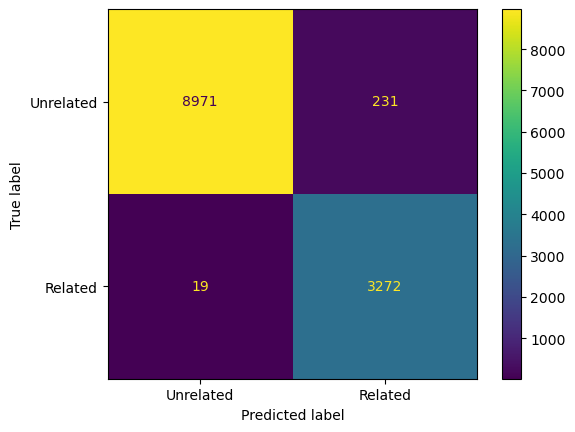

In [47]:
BertDataLoader = dataset(headlines,bodies,labels,False)
train_size = int(0.75 * len(BertDataLoader))
test_size = len(BertDataLoader) - train_size
train_dataset,test_dataset = random_split(BertDataLoader,[train_size,test_size])
train_loader = DataLoader(train_dataset,batch_size=32)
test_loader = DataLoader(test_dataset,batch_size=32)

Evaluate(model,test_loader,'',Final=True)

<h1> Three Class Problem </h1>

In [48]:

DataSetThreeClass = LoadDataSet('AgreeDisagreeDiscuss')
DataSetThreeClass.iloc(0)[0]



Headline                Seth Rogen to Play Apple’s Steve Wozniak
Body ID                                                      712
Stance                                                         1
articleBody    Danny Boyle is directing the untitled film\n\n...
Name: 1, dtype: object

<h3> Get Embeddings for Three Class problem </h3>

In [69]:
BERTTokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
BERTModel = BertModel.from_pretrained('bert-base-uncased')
BERTModel = BERTModel.to(device)
BATCH_SIZE = 32
headlines = list(DataSetThreeClass['Headline'])
bodies = list(DataSetThreeClass['articleBody'])
labels = list(DataSetThreeClass['Stance'])

In [70]:
DIRECTORY = './'
if not os.path.exists(DIRECTORY+'/Transformer3-Class-TOKENS.pickle'):

  embeddingsThreeClass = torch.empty((len(headlines),768))    #Each embedding is 768 length there are len(headlines) embeddings
  for i in tqdm.tqdm(range(0,len(headlines),BATCH_SIZE)):
      headline = headlines[i:i+BATCH_SIZE]
      body = bodies[i:i+BATCH_SIZE]
      tokens = BERTTokenizer(text=headline,text_pair=body,return_tensors='pt',truncation='only_second',padding=True)
      tokens = tokens.to(device)
      with torch.no_grad():
          outputs = BERTModel(**tokens)
      embeddingsThreeClass[i:i+BATCH_SIZE] = outputs[0][:,0,:]
  with open(DIRECTORY+'/Transformer3-Class-TOKENS.pickle','wb') as file:
    pickle.dump(embeddings,file)

else:
  with open(DIRECTORY+'/Transformer3-Class-TOKENS.pickle','rb') as file:
    embeddingsThreeClass = pickle.load(file)

In [71]:
#Code adapted from https://www.kaggle.com/code/mehmetlaudatekman/lstm-text-classification-pytorch


class LSTMBert3Class(nn.Module):
    def __init__(self):
        super(LSTMBert3Class,self).__init__()
        
        self.lstm = nn.LSTM(768,256,num_layers=2,bidirectional=True,dropout=0.5,batch_first=True)
        
        
        self.linear1 = nn.Linear(512,128)
        self.linear2 = nn.Linear(128,64)
        self.linear3 = nn.Linear(64,32)
        self.linear4 = nn.Linear(32,3)
        
        self.drop = nn.Dropout(p=0.4)
    def forward(self,x):
        #
        x = x.unsqueeze(1)
        
        
        
        lstm_output,(hidden,cn) = self.lstm(x)
        
        hidden = self.drop(torch.cat((hidden[-2,:,:],hidden[-1,:,:]),dim=1))
        output = self.drop(hidden)
        output = nn.functional.relu(self.linear1(hidden))
        output = self.drop(output)
        output = nn.functional.relu(self.linear2(output))
        output = self.drop(output)
        output = nn.functional.relu(self.linear3(output))
        output = self.drop(output)
        output = (self.linear4(output))
        
        
        #out = nn.functional.softmax(output,dim=1)   #No softmax for 3 class on cross entropy loss
        return output
    
class TransformerBert3Class(nn.Module):
    def __init__(self,seq_length=10):
        super(TransformerBert3Class,self).__init__()
        self.seq_length = seq_length
        nhead = 8
        num_encoder_layers=2
        dim_feedforward=2048
        dropout=0.1
        encoder_layers = nn.TransformerEncoderLayer(d_model=768,nhead=nhead,dim_feedforward=dim_feedforward,dropout=0.1)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers,num_layers=num_encoder_layers)
        
        self.linear1 = nn.Linear(768,3)
       
        self.drop = nn.Dropout(p=0.1)  
    
    def forward(self,x):
        x = x.unsqueeze(1).repeat(1,self.seq_length,1)
        x = x.permute(1,0,2)
        
        output = self.transformer_encoder(x)
        output = output[1]
        #print(output)
        output = self.drop(output)
        output = self.linear1(output)
        #output = self.linear2(output)
        
        output = nn.functional.softmax(output,dim=1)
        #print(output)
        return output

In [72]:
def EvaluateThreeClass(model,loader,name,log=True):
    model.eval()
    
    Predictions = []
    TrueValues = []
    with torch.no_grad():
        for i,batch in enumerate(loader):
            
            
            X,y = batch[0],batch[1]

            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            predictedClass = torch.max(pred,1)[1]
            Predictions.extend(predictedClass.cpu().numpy())
            TrueValues.extend(y.cpu().numpy())
            #print(y)
    auc = plot_roc_curve(TrueValues, Predictions)
    if log ==False:
        
        CM = confusion_matrix(TrueValues,Predictions,labels=[0,1,2])
        disp = ConfusionMatrixDisplay(confusion_matrix=CM,display_labels=['Disagree','Discuss','Agree'])
        disp.plot()
        #plot_confusion_matrix(TrueValues,Predictions)
        print(classification_report(TrueValues,Predictions,labels=[0,1,2],target_names=['Disagree','Discuss','Agree'],digits=6))
    else:
        
        file = open(f'{name}.txt','a')

        fpr, tpr, thresholds = roc_curve(TrueValues, Predictions, pos_label=1)
        #roc_auc= auc(fpr,tpr)
        print(f'Evaluation AUC: {auc}')
        accuracy = accuracy_score(TrueValues,Predictions)
        print(f'Evaluation Accuracy: {accuracy}')
        f1 = f1_score(TrueValues,Predictions,average='micro')
        print(f'F1 Score: {f1}')
        print('\n')
        file.writelines(f'ROC:{auc},ROC:{accuracy},F1:{f1}\n')

In [73]:
modelThreeClass = LSTMBert3Class()
modelThreeClass

LSTMBert3Class(
  (lstm): LSTM(768, 256, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (linear1): Linear(in_features=512, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=32, bias=True)
  (linear4): Linear(in_features=32, out_features=3, bias=True)
  (drop): Dropout(p=0.4, inplace=False)
)

13427


315it [00:01, 165.77it/s]


Epoch: 1,Loss: 1.0886804567443


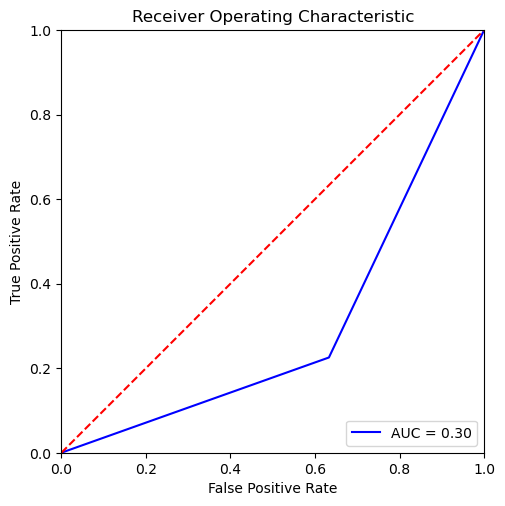

Evaluation AUC: 0.29621829897070867
Evaluation Accuracy: 0.6803693774203158
F1 Score: 0.6803693774203158




315it [00:01, 218.79it/s]


Epoch: 2,Loss: 1.0318622534237212


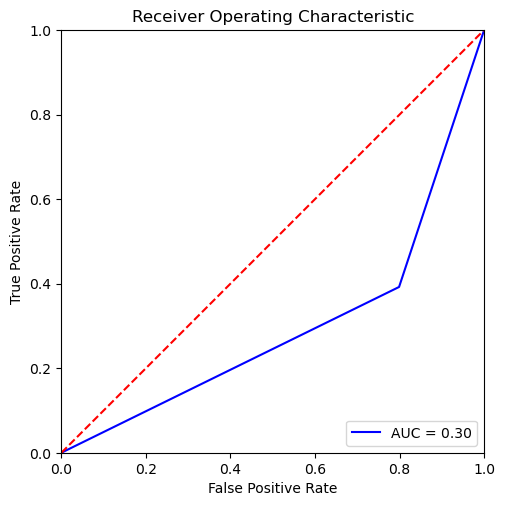

Evaluation AUC: 0.2966609942407945
Evaluation Accuracy: 0.6157283288650581
F1 Score: 0.6157283288650581




315it [00:01, 219.07it/s]


Epoch: 3,Loss: 1.0043715333181715


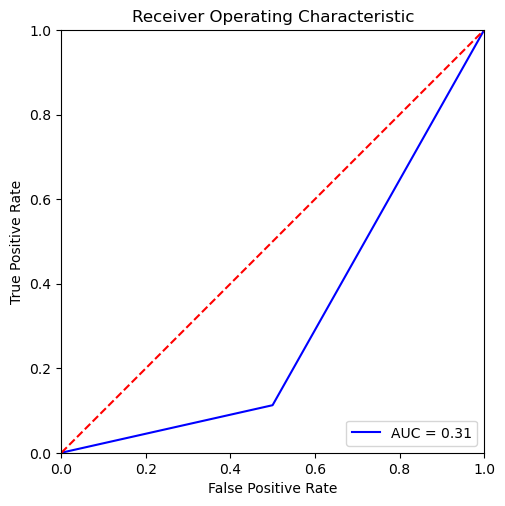

Evaluation AUC: 0.3064256891044975
Evaluation Accuracy: 0.7173071194518915
F1 Score: 0.7173071194518915




315it [00:01, 219.65it/s]


Epoch: 4,Loss: 0.9805570290202186


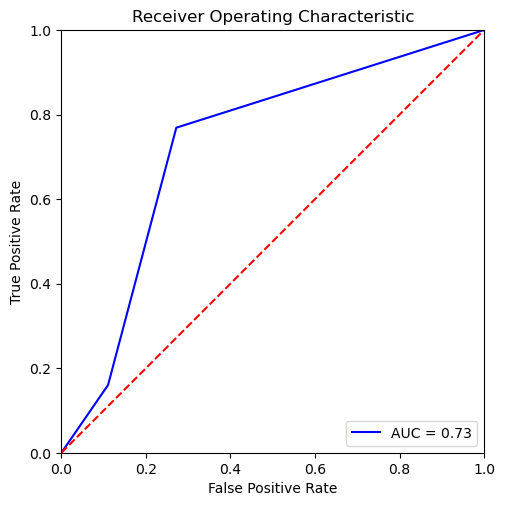

Evaluation AUC: 0.727863252204944
Evaluation Accuracy: 0.49002085195114686
F1 Score: 0.49002085195114686




315it [00:01, 208.41it/s]


Epoch: 5,Loss: 0.9749816044928535


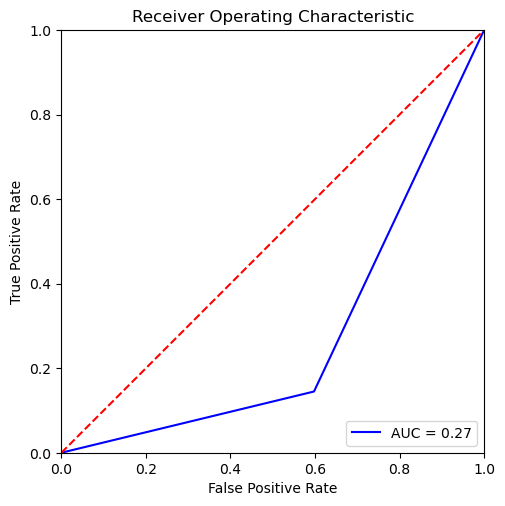

Evaluation AUC: 0.2736277438772724
Evaluation Accuracy: 0.7217753946976467
F1 Score: 0.7217753946976467




315it [00:01, 204.11it/s]


Epoch: 6,Loss: 0.9657693794795446


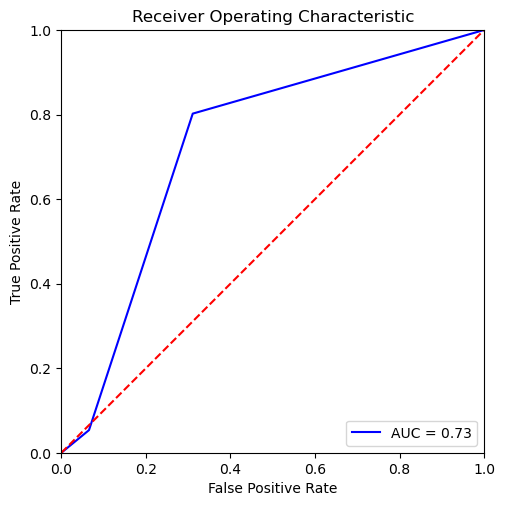

Evaluation AUC: 0.7278553150418765
Evaluation Accuracy: 0.5677688412272862
F1 Score: 0.5677688412272862




315it [00:01, 203.43it/s]


Epoch: 7,Loss: 0.9530886426804558


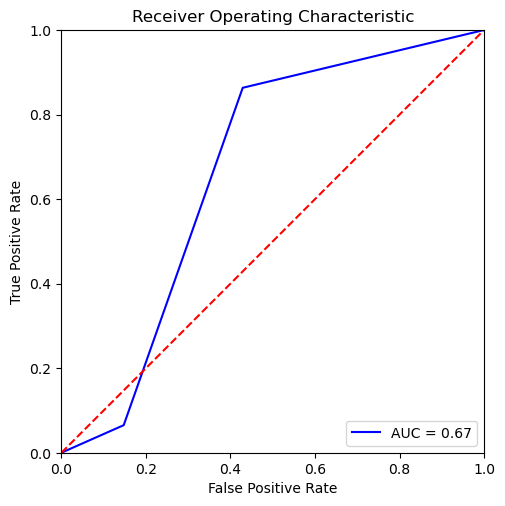

Evaluation AUC: 0.6675388286017259
Evaluation Accuracy: 0.6175156389633601
F1 Score: 0.6175156389633601




315it [00:01, 205.01it/s]


Epoch: 8,Loss: 0.9323227227680266


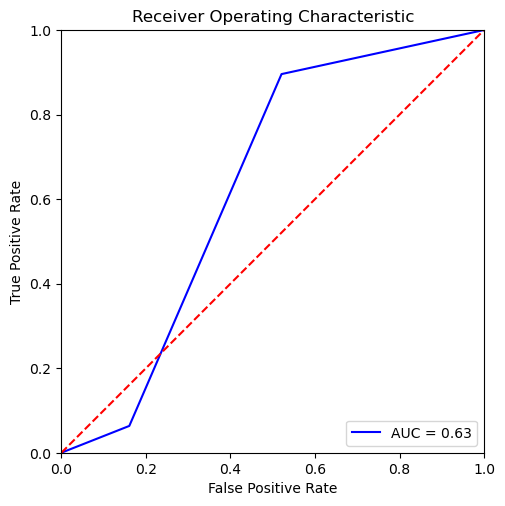

Evaluation AUC: 0.6320390730663483
Evaluation Accuracy: 0.6333035448316949
F1 Score: 0.6333035448316949




315it [00:01, 213.35it/s]


Epoch: 9,Loss: 0.9314118400452629


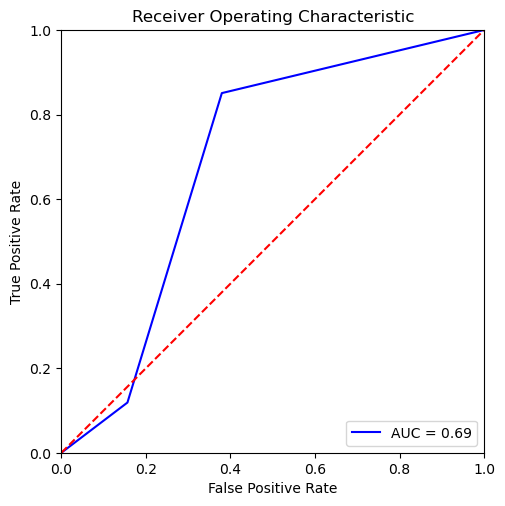

Evaluation AUC: 0.6916729634827002
Evaluation Accuracy: 0.5811736669645516
F1 Score: 0.5811736669645516




315it [00:01, 199.21it/s]


Epoch: 10,Loss: 0.9226048013520619


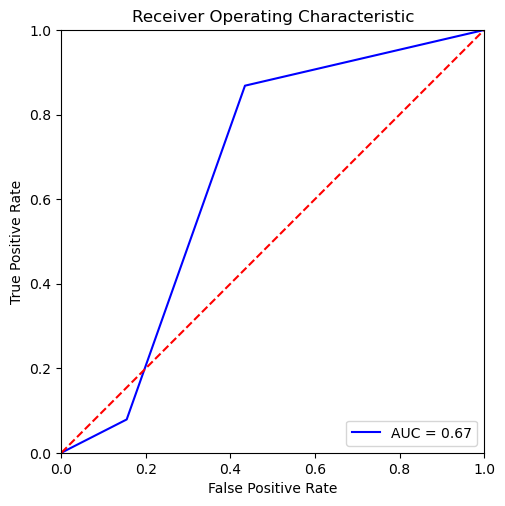

Evaluation AUC: 0.6670356124632509
Evaluation Accuracy: 0.6118558236520703
F1 Score: 0.6118558236520703




In [74]:
TRAIN = True
modelThreeClass = LSTMBert3Class()
print(len(headlines))
modelThreeClass = modelThreeClass.to(device)
modelThreeClass.train()
if (not os.path.exists(DIRECTORY+'/LSTM_BERT_3CLASS')) or TRAIN==True:
    BertThreeClassDataLoader = dataset(headlines,bodies,labels,False,ThreeClass=True)
    train_size = int(0.75 * len(BertThreeClassDataLoader))
    test_size = len(BertThreeClassDataLoader) - train_size
    train_dataset,test_dataset = random_split(BertThreeClassDataLoader,[train_size,test_size])    #Use this to calculate the weights, takes too long with BERT loader as tokens need to be generated 
    classCounts = {0:0,1:0,2:0}

    for _,label in train_dataset:
        temp = (int(label.cpu().numpy()))
        classCounts[temp] += 1
        #Inbalance more class 0 then 1
    counts = [classCounts[0],classCounts[1],classCounts[2]]
    total = sum(counts)
    
    weights = [total / c for c in counts]
    weights = torch.FloatTensor(weights).to(device)
    train_dataset,test_dataset = random_split(BertThreeClassDataLoader,[train_size,test_size])
    train_loader = DataLoader(train_dataset,batch_size=32,shuffle=True)
    test_loader = DataLoader(test_dataset,batch_size=32)
    Train(modelThreeClass,train_loader,10,weights,'LSTM_BERT_3CLASS',ThreeClass=True)
    torch.save(modelThreeClass.state_dict(),'LSTM_BERT_3CLASS')
else:
    modelThreeClass.load_state_dict(torch.load('LSTM_BERT_3CLASS'))
    modelThreeClass.eval()


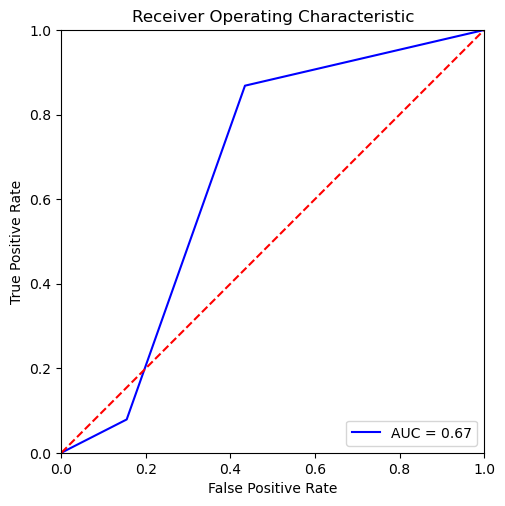

              precision    recall  f1-score   support

    Disagree   0.169165  0.699115  0.272414       226
     Discuss   0.847082  0.789568  0.817314      2224
       Agree   0.400000  0.154355  0.222753       907

    accuracy                       0.611856      3357
   macro avg   0.472082  0.547679  0.437494      3357
weighted avg   0.680650  0.611856  0.619991      3357



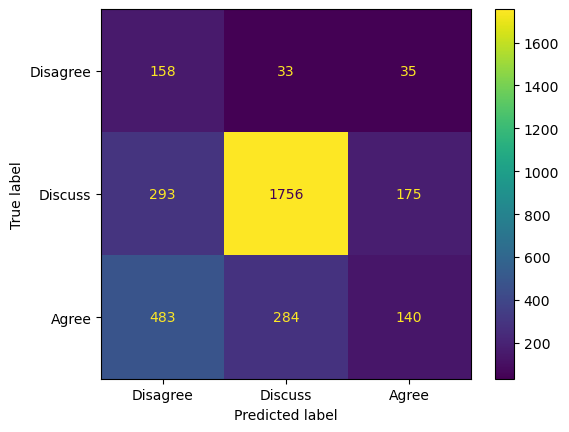

In [75]:
EvaluateThreeClass(modelThreeClass,test_loader,'af',log=False)

<h1> End To End </h1>

<p> Use Competition CSV for end to end test <p>

In [76]:
EndToEndBodies = pd.read_csv('competition_test_bodies.csv')
EndToEndStances = pd.read_csv('competition_test_stances.csv')
MainDataEndToEnd = EndToEndStances.merge(EndToEndBodies,on='Body ID')
MainDataEndToEnd['Stance']


Mapper = {'unrelated':-1,'disagree':0,'discuss':1,'agree':2}

MainDataEndToEnd['Stance'] = MainDataEndToEnd['Stance'].map(Mapper)

In [77]:
DIRECTORY = './'
if not os.path.exists(DIRECTORY+'/TransformerEndToEndTOKENS.pickle'):

  headlines = list(MainDataEndToEnd['Headline'])
  bodies = list(MainDataEndToEnd['articleBody'])
  EndToEndEmbeddings = torch.empty((len(headlines),768))    #Each embedding is 768 length there are len(headlines) embeddings
  for i in tqdm.tqdm(range(0,len(headlines),BATCH_SIZE)):
      headline = headlines[i:i+BATCH_SIZE]
      body = bodies[i:i+BATCH_SIZE]
      tokens = BERTTokenizer(text=headline,text_pair=body,return_tensors='pt',truncation='only_second',padding=True)
      tokens = tokens.to(device)
      with torch.no_grad():
          outputs = BERTModel(**tokens)
      EndToEndEmbeddings[i:i+BATCH_SIZE] = outputs[0][:,0,:]
  with open(DIRECTORY+'/TransformerEndToEndTOKENS.pickle','wb') as file:
    pickle.dump(embeddings,file)

else:
  with open(DIRECTORY+'/TransformerEndToEndTOKENS.pickle','rb') as file:
    EndToEndEmbeddings = pickle.load(file)


In [78]:
headlines = list(MainDataEndToEnd['Headline'])
bodies = list(MainDataEndToEnd['articleBody'])
labels = list(MainDataEndToEnd['Stance'])

In [79]:
import time

In [80]:
def EvaluationEndToEnd(TwoClassModel,ThreeClassModel,Loader):
    TrueValues = []
    PredictedValues = []
    
    with torch.no_grad():
        for i,batch in tqdm.tqdm(enumerate(Loader)):
            
            
            X,y = batch[0],batch[1]

            X = X.to(device)
            y = y.to(device)
            y = torch.max(y)
           
            FirstPrediction = TwoClassModel(X)
            
            predictedClass = int(torch.max(FirstPrediction,1)[1][0]) #output 0 = unrelated = -1
            
           
            
            #time.sleep(2)
            if predictedClass != 0:
                
                SecondPredicted = ThreeClassModel(X)
                
                FinalPredictedClass = int(torch.max(SecondPredicted,1)[1])
                #print(FinalPredictedClass)
            else:
                #print('NOT ZERO !')
                FinalPredictedClass = -1
            #print(FinalPredictedClass)
            PredictedValues.append(FinalPredictedClass)
            TrueValues.append(int(y))
    #plot_confusion_matrix(TrueValues,PredictedValues)
    CM = confusion_matrix(TrueValues,PredictedValues)
    disp = ConfusionMatrixDisplay(confusion_matrix=CM,display_labels=['Unrelated','Disagree','Discuss','Agree'])
    disp.plot()
    print(classification_report(TrueValues,PredictedValues,labels=[-1,0,1,2],target_names=['Unrelated','Disagree','Discuss','Agree'],digits=6))
    auc = plot_roc_curve(TrueValues, PredictedValues)
    return TrueValues,PredictedValues

LSTMBert(
  (lstm): LSTM(768, 256, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (linear): Linear(in_features=512, out_features=2, bias=True)
  (drop): Dropout(p=0.3, inplace=False)
)


25413it [00:22, 1112.87it/s]


              precision    recall  f1-score   support

   Unrelated   0.993913  0.969917  0.981768     18349
    Disagree   0.151205  0.657102  0.245840       697
     Discuss   0.744517  0.562724  0.640980      4464
       Agree   0.262681  0.152391  0.192883      1903

    accuracy                       0.828592     25413
   macro avg   0.538079  0.585533  0.515368     25413
weighted avg   0.872235  0.828592  0.842648     25413



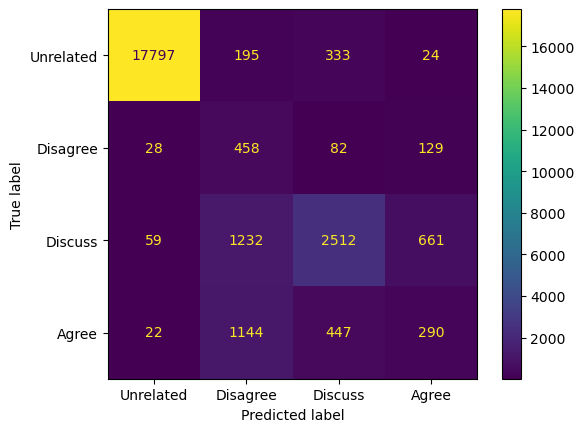

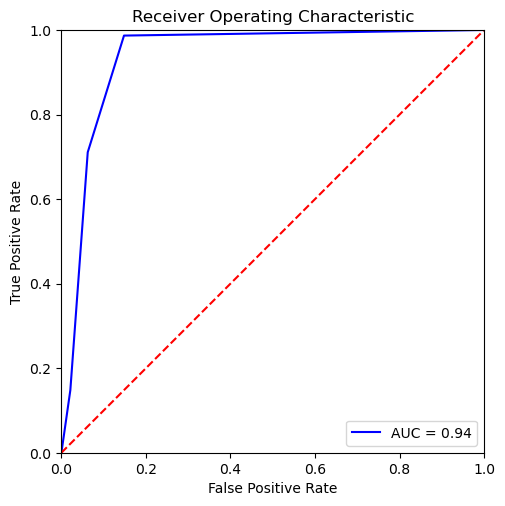

In [81]:
EndToEndDataset = dataset(headlines,bodies,labels,Tfidf=False,EndToEnd=True)
print(model)
EndToEndLoader = DataLoader(EndToEndDataset,batch_size=1)
EvaluationEndToEnd(model,modelThreeClass,EndToEndLoader)
pass